# 4장. 이미지 분류

텐서플로를 활용한 구글넷 구현

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


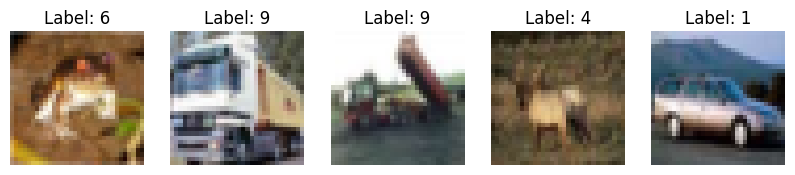

In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
num_classes = 10

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_x[i])
    plt.title(f"Label: {train_y[i][0]}")
    plt.axis('off')
plt.show()

In [ ]:
print(f'스케일링 전 픽셀의 최대 값과 최소 값: {train_x.min()}~{train_x.max()}')
train_x= train_x/255.
test_x = test_x//255.
print(f'스케일링 후 픽셀의 최대 값과 최소 값: {train_x.min()}~{train_x.max()}')

스케일링 전 픽셀의 최대 값과 최소 값: 0~255
스케일링 후 픽셀의 최대 값과 최소 값: 0.0~1.0


In [ ]:
image_size = (32, 32)
batch_size = 64
weight_decay = 5e-4
learning_rate = 1e-2
epochs = 40

In [ ]:
def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(scale=False, axis=3)(x)
    x = Activation('relu')(x)
    return x


In [ ]:
def inception_module(x, filters_num_array, weight_decay=.0):
    (br0_filters, br1_filters, br2_filters, br3_filters) = filters_num_array
    br0 = conv2d_bn_relu(x, filters=br0_filters, kernel_size=1, weight_decay=weight_decay)
    br1 = conv2d_bn_relu(x, filters=br1_filters[0], kernel_size=1, weight_decay=weight_decay)
    br1 = conv2d_bn_relu(br1, filters=br1_filters[1], kernel_size=3, weight_decay=weight_decay)
    br2 = conv2d_bn_relu(x, filters=br2_filters[0], kernel_size=1, weight_decay=weight_decay)
    br2 = conv2d_bn_relu(br2, filters=br2_filters[1], kernel_size=5)
    br3 = MaxPool2D(pool_size=3, strides=(1, 1), padding='same')(x)
    br3 = conv2d_bn_relu(br3, filters=br3_filters, kernel_size=1, weight_decay=weight_decay)
    x = concatenate([br0, br1, br2, br3], axis=3)
    return x

In [ ]:
def googlenet(input_shape, classes, weight_decay=.0):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=64, kernel_size=1, weight_decay=weight_decay)
    x = conv2d_bn_relu(x, filters=192, kernel_size=3, weight_decay=weight_decay)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    x = inception_module(x, (64, (96, 128), (16, 32), 32), weight_decay=weight_decay)
    x = inception_module(x, (128, (128, 192), (32, 96), 64), weight_decay=weight_decay)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
    x = inception_module(x, (192, (96, 208), (16, 48), 64), weight_decay=weight_decay)
    x = inception_module(x, (160, (112, 224), (24, 64), 64), weight_decay=weight_decay)
    x = inception_module(x, (128, (128, 256), (24, 64), 64), weight_decay=weight_decay)
    x = inception_module(x, (112, (144, 288), (32, 64), 64), weight_decay=weight_decay)
    x = inception_module(x, (256, (160, 320), (32, 128), 128), weight_decay=weight_decay)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
    x = inception_module(x, (256, (160, 320), (32, 128), 128), weight_decay=weight_decay)
    x = inception_module(x, (384, (192, 384), (48, 128), 128), weight_decay=weight_decay)
    x = AveragePooling2D(pool_size=4, strides=1, padding='valid')(x)
    x = Flatten(name='flatten')(x)
    output = Dense(classes, activation='softmax')(x)
    model = Model(input, output)
    return model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import concatenate


googlenet = googlenet(input_shape=(image_size[0], image_size[1], 3),
                      classes=num_classes,
                      weight_decay=weight_decay)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
googlenet.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=1e-7, verbose=1)

In [ ]:
history = googlenet.fit(x=train_x,
                        y=train_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.2,
                        callbacks = [reduce_lr])

Epoch 1/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 3507s 6s/step - accuracy: 0.3980 - loss: 5.4856 - val_accuracy: 0.5037 - val_loss: 4.9403 - learning_rate: 0.0100
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 3493s 6s/step - accuracy: 0.6549 - loss: 4.3957 - val_accuracy: 0.6567 - val_loss: 4.1251 - learning_rate: 0.0100
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 3429s 5s/step - accuracy: 0.7461 - loss: 3.7798 - val_accuracy: 0.6861 - val_loss: 3.7339 - learning_rate: 0.0100
Epoch 4/40
415/625 ━━━━━━━━━━━━━━━━━━━━ 18:11 5s/step - accuracy: 0.8036 - loss: 3.3189

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

keras applications를 활용한 레즈넷 실습

In [ ]:
!gdown 1WI3FPChY3DFnrNEP3Fk_C61bcMxkr4-b


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions

# ResNet 모델 불러오기
resnet_model = ResNet50(weights='imagenet', include_top=True)

# 이미지 전처리 및 예측
PATH = './'
FILE_NAME = '4-7-푸들.png'
img = image.load_img(PATH + FILE_NAME, target_size=(224, 224))
input_image = image.img_to_array(img)
input_image = preprocess_input(input_image)
input_image = tf.expand_dims(input_image, axis=0)

predictions = resnet_model.predict(input_image)
decoded_predictions = decode_predictions(predictions, top=3)[0]

for class_id, class_name, probability in decoded_predictions:
  print(f"{class_name} 확률: {probability:.2f}%")

이피션트넷 실습

In [ ]:
!gdown 1WI3FPChY3DFnrNEP3Fk_C61bcMxkr4-b


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

# 이피션트넷 모델 불러오기
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=True)

In [ ]:
efficientnet_model.summary()


In [ ]:
# 이미지 전처리 및 예측
PATH = './'
FILE_NAME = '4-7-푸들.png'
img = image.load_img(PATH + FILE_NAME, target_size=(224, 224))
input_image = image.img_to_array(img)
input_image = preprocess_input(input_image)
input_image = tf.expand_dims(input_image, axis=0)

predictions = efficientnet_model.predict(input_image)
decoded_predictions = decode_predictions(predictions, top=3)[0]

for class_id, class_name, probability in decoded_predictions:
  print(f"{class_name} 확률: {probability:.2f}%")

비전 트랜스포머(ViT) 모델 구현 실습

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

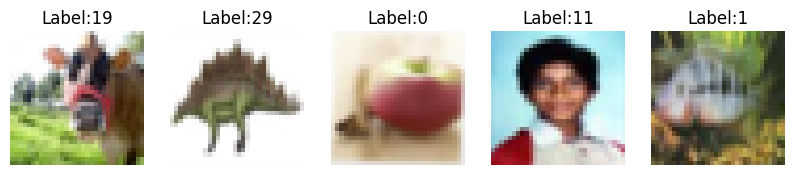

In [ ]:
(train_x, train_y), (test_x, test_y)= tf.keras.datasets.cifar100.load_data()
num_classes=100

plt.figure(figsize=(10,2))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(train_x[i])
  plt.title(f'Label:{train_y[i][0]}')
  plt.axis('off')
plt.show()

In [ ]:
print(f'스케일링 전 픽셀의 최대 값과 최소 값: {train_x.min()}~{train_x.max()}')
train_x= train_x/255.
test_x = test_x/255.
print(f'스케일링 후 픽셀의 최대 값과 최소 값:{train_x.min()}~{train_x.max()}')

스케일링 전 픽셀의 최대 값과 최소 값: 0~255
스케일링 후 픽셀의 최대 값과 최소 값:0.0~1.0


In [ ]:
#모델 파라미터 정의
input_shape= (32,32,3)
batch_size= 64

image_size = 72
patch_size= 6
num_patches =(image_size // patch_size) **2

learning_rate = 1e-3
weight_decay = 1e-4
epochs = 30

transformer_layers = 4
projection_dim = 64
num_heads =4
transformer_units = [projection_dim *2 , projection_dim]
mlp_head_units = [2048,1024]

In [ ]:
##트랜스포머 인코더의 입력으로 넣어줄 이미지 조각을 만들어주는 클래스 정의
class PatchTokenization(layers.Layer):
    def __init__(self, image_size=image_size, patch_size=patch_size, num_patches=num_patches, projection_dim=projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        tokens = self.projection(flat_patches)
        return (tokens, patches)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'patch_tokenization_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


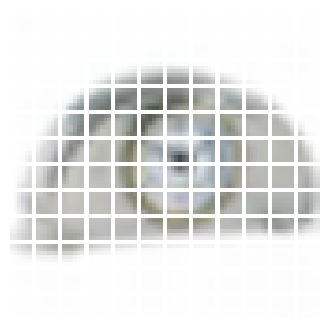

In [ ]:
image = train_x[np.random.choice(range(train_x.shape[0]))]
resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))

(token, patch) = PatchTokenization()(resized_image)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (patch_size, patch_size, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

In [ ]:
#패치 인코더
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches=num_patches, projection_dim=projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
#퍼셉트론 함수
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x= layers.Dense(units, activation= tf.nn.relu)(x)
    x= layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    x = layers.Normalization()(inputs)
    x = layers.Resizing(image_size, image_size)(x)
    (tokens, _) = PatchTokenization()(x)
    encoded_patches = PatchEncoder()(tokens)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
class CosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("total_steps 값이 warmup_steps보다 크거나 같아야합니다.")

        cos_annealed_lr = tf.cos(self.pi * (tf.cast(step, tf.float32) - self.warmup_steps) / float(self.total_steps - self.warmup_steps))
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "learning_rate_base 값이 warmup_learning_rate보다 크거나 같아야합니다.")
            slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(step < self.warmup_steps, warmup_rate, learning_rate)
        return tf.where(step > self.total_steps, 0.0, learning_rate, name="learning_rate")

In [ ]:
total_steps = int((len(train_x) / batch_size) * epochs)
warmup_epoch_percentage = 0.10
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = CosineDecay(
    learning_rate_base=learning_rate,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,)

In [ ]:
vit = create_vit_classifier()

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=scheduled_lrs,
    weight_decay=weight_decay)

vit.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'patch_tokenization_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
history= vit.fit(
    x=train_x,
    y= train_y,
    batch_size= batch_size,
    epochs= epochs,
    validation_split=0.2
)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1677s 3s/step - accuracy: 0.0106 - loss: 5.6681 - top-5-accuracy: 0.0519 - val_accuracy: 0.0148 - val_loss: 4.6075 - val_top-5-accuracy: 0.0653
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1802s 3s/step - accuracy: 0.0125 - loss: 4.5993 - top-5-accuracy: 0.0629 - val_accuracy: 0.0152 - val_loss: 4.5418 - val_top-5-accuracy: 0.0846
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1609s 3s/step - accuracy: 0.0146 - loss: 4.5852 - top-5-accuracy: 0.0641 - val_accuracy: 0.0116 - val_loss: 4.5586 - val_top-5-accuracy: 0.0706
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1635s 3s/step - accuracy: 0.0095 - loss: 4.6175 - top-5-accuracy: 0.0502 - val_accuracy: 0.0090 - val_loss: 4.6104 - val_top-5-accuracy: 0.0500
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1599s 2s/step - accuracy: 0.0099 - loss: 4.6057 - top-5-accuracy: 0.0491 - val_accuracy: 0.0077 - val_loss: 4.6074 - val_top-5-accuracy: 0.0416
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1596s 3s/step - accuracy: 0.0108 - loss:

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['top-5-accuracy'], label='Training Top-5 Accuracy')
plt.plot(history.history['val_top-5-accuracy'], label='Validation Top-5 Accuracy')
plt.title('Training and Validation Top-5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
vit.evaluate(test_x, test_y)


swin transformer


In [ ]:
!pip insatll tfswin

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tfswin import SwinTransformerTiny224, preprocess_input
import matplotlib.pyplot as plt

In [ ]:
(train_x, train_y),(test_x, test_y) = tf.keras.datasets.cifar100.load_data()
num_classes =100

In [ ]:
inputs = layers.Input(shape=(32,32,3), dtype='uint8')
outputs= layers.Lambda(preprocess_input)(inputs)
outputs = SwinTransformerTiny224(include_top=False)(outputs)
outputs= layers.Dense(num_classes, activation='softmax')(outputs)

swin = models.Model(inputs=inputs, outputs=ouputs)

In [ ]:
optimizer = tf.keras.optimizers,AdamW()

swin.compile(
    optimizer= optimizier,
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(1, name='accuracy'),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy')]
)

In [ ]:
history= swin.fit(x=train_x, y=train_y, batch_size=128, epochs=10, validation_split=0.2)

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['top-5-accuracy'], label='Training Top-5 Accuracy')
plt.plot(history.history['val_top-5-accuracy'], label='Validation Top-5 Accuracy')
plt.title('Training and Validation Top-5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
swin.evaluate(test_x, test_y)


# 5장. 객체 탐지


### 텐서플로를 활용한 Faster R-CNN 실습

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models


In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
pip install protobuf==3.20.*


In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
%matplotlib inline

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
hub_model = hub.load('https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1')

In [ ]:
!wget https://raw.githubusercontent.com/Lilcob/test_colab/main/three%20young%20man.jpg
image_path = '/content/three young man.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_np = np.array([image])

In [ ]:
results = hub_model(image_np)
result = {key: value.numpy() for key, value in results.items()}
print(result.keys())

label_id_offset = 0
image_np_with_detections = image_np.copy()

In [ ]:
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections[0],result['detection_boxes'][0],
(result['detection_classes'][0] + label_id_offset).astype(int),
 result['detection_scores'][0],category_index,use_normalized_coordinates=True, max_boxes_to_draw=200,min_score_thresh=.30,
agnostic_mode=False)
plt.figure(figsize=(12, 12))
plt.imshow(image_np_with_detections[0])
plt.show()
